In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import xarray as xr

import random
from IPython.display import HTML

import IPython

import cartopy.feature as cfeature

from herbie import Herbie_latest, FastHerbie, Herbie
from toolbox import EasyMap, pc, ccrs
import metpy
from metpy.units import units
from paint.standard2 import cm_tmp

from pyart.graph import cm_colorblind 
import xmovie
# I like Py-ART's colorblind freindly colormaps

In [2]:
mt = "2023-01-16 00:00"
nfcst = 47

In [3]:
qstr = "(:CLMR:.*hybrid|:HGT:.*hybrid)"


H = Herbie(
    mt,  # model run date
    model="hrrr",  # model name
    product="nat",  # model produce name (model dependent)
    fxx=0,  # forecast lead time
)
H.read_idx(searchString=qstr)

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Jan-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/scollis/miniconda3/envs/models/lib/python3.11/site-packages/herbie/archive.py:692: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
1,2,2257256,2293487,2257256-2293487,2023-01-16,2023-01-16,CLMR,1 hybrid level,anl,:CLMR:1 hybrid level:anl
12,13,4531769,6823226,4531769-6823226,2023-01-16,2023-01-16,HGT,1 hybrid level,anl,:HGT:1 hybrid level:anl
21,22,15747620,15824667,15747620-15824667,2023-01-16,2023-01-16,CLMR,2 hybrid level,anl,:CLMR:2 hybrid level:anl
32,33,18075504,20431283,18075504-20431283,2023-01-16,2023-01-16,HGT,2 hybrid level,anl,:HGT:2 hybrid level:anl
41,42,29287177,29369530,29287177-29369530,2023-01-16,2023-01-16,CLMR,3 hybrid level,anl,:CLMR:3 hybrid level:anl
...,...,...,...,...,...,...,...,...,...,...
952,953,521948401,523446398,521948401-523446398,2023-01-16,2023-01-16,HGT,48 hybrid level,anl,:HGT:48 hybrid level:anl
961,962,531059919,531060107,531059919-531060107,2023-01-16,2023-01-16,CLMR,49 hybrid level,anl,:CLMR:49 hybrid level:anl
972,973,532343163,533853063,532343163-533853063,2023-01-16,2023-01-16,HGT,49 hybrid level,anl,:HGT:49 hybrid level:anl
981,982,541641536,541641724,541641536-541641724,2023-01-16,2023-01-16,CLMR,50 hybrid level,anl,:CLMR:50 hybrid level:anl


In [4]:
%%capture 
#Handles warnings..

FH = FastHerbie([mt], model="hrrr",product="nat",source='aws', fxx=range(0,nfcst))
FH.download(qstr, max_threads=1) #This needs a good (and cheap) internet connection... ONE HOUR on my connection

In [49]:
%%capture 
#Handles warnings..

ds = FH.xarray(qstr, remove_grib=False)


In [50]:
ds

<xarray.Dataset>
Dimensions:              (step: 47, hybrid: 50, y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2023-01-16
  * step                 (step) timedelta64[ns] 00:00:00 ... 1 days 22:00:00
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           (step) datetime64[ns] 2023-01-16 ... 2023-01-17T22:0...
Dimensions without coordinates: y, x
Data variables:
    gh                   (step, hybrid, y, x) float32 10.65 10.65 ... 2.655e+04
    clwmr                (step, hybrid, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    searchString:            (:CLMR:.*hybrid|:HGT:.*hybrid)

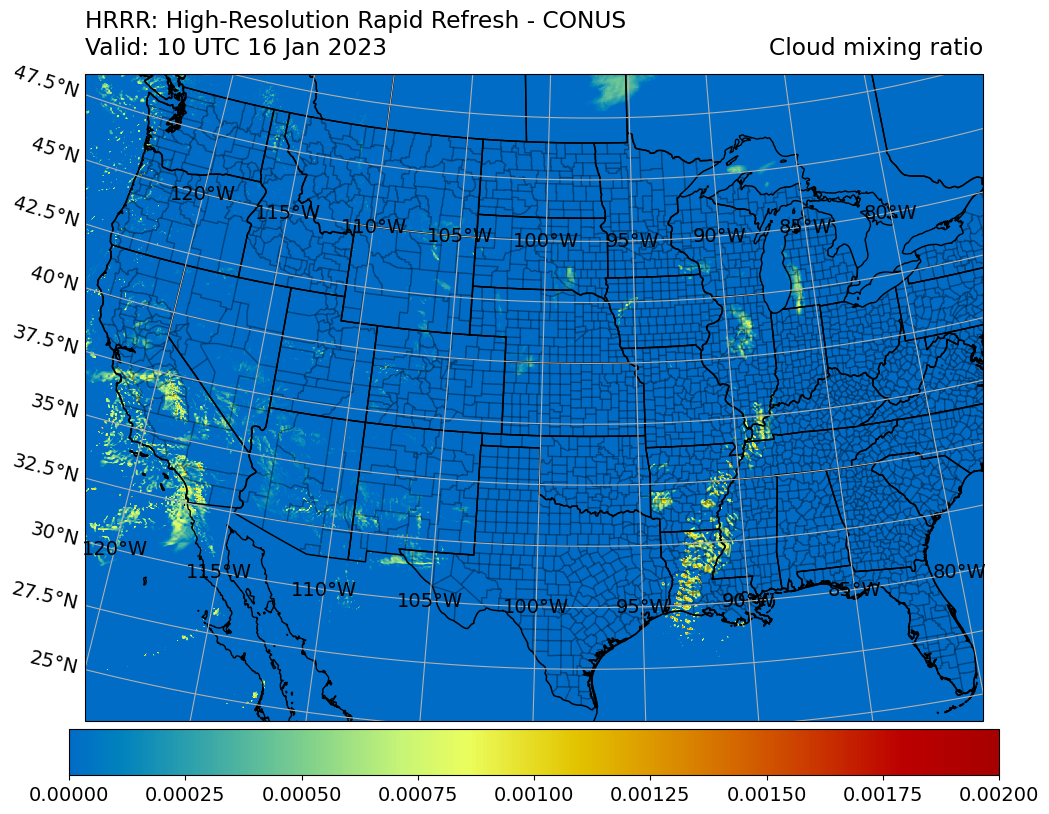

In [63]:
tt=10

fig = plt.figure(figsize=[15,10])
ax = fig.subplots( ncols=1, 
                  subplot_kw={'autoscale_on': False,
                              'projection' : ds.herbie.crs})

p = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.clwmr.isel(step=tt).isel(hybrid=10),
        transform=pc,
        cmap=cm_colorblind.HomeyerRainbow,
        vmin=0, vmax=.002
    )

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

counties = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                            edgecolor='black', name='admin_2_counties_lakes', alpha=.2)

ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
ax.add_feature(coast, facecolor='none', edgecolor='black')
ax.add_feature(counties, facecolor='none', edgecolor='black')

plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8
)

ax.set_title(
    f"{ds.model.upper()}: {ds.description}\nValid: {ds.valid_time[tt].dt.strftime('%H UTC %d %b %Y').item()}",
    loc="left",
)

ax.set_title(ds.clwmr.GRIB_name, loc="right")
ax.set_extent([-120, -80, 50, 25], crs=pc)
gl = ax.gridlines(xlocs=np.linspace(-120,-80,9), ylocs=np.linspace(50.,25.,11),draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True 

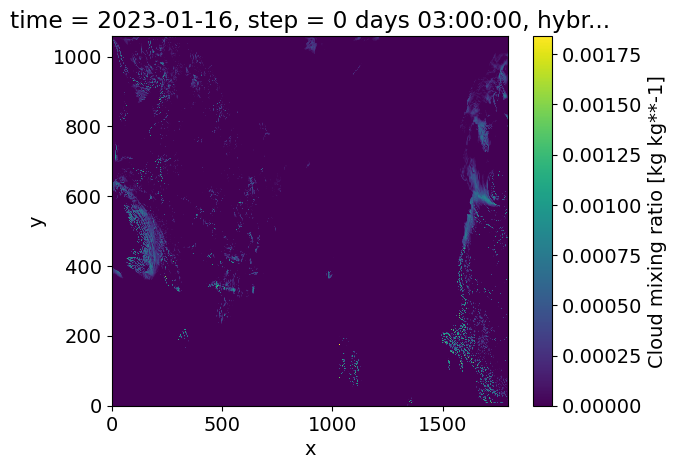

In [11]:
ds.clwmr.isel(step=3, hybrid=10).plot()

'gpm'

In [45]:
dsi = ds.herbie.nearest_points([(-87.6298, 41.8781), (-87.9789, 41.7183), (-87.9646831, 41.8031498)], 
                               names=["Chicago", "Argonne", "Barn"])
dsi

/Users/scollis/miniconda3/envs/models/lib/python3.11/site-packages/metpy/xarray.py:382: UserWarning: More than one time coordinate present for variable "gh".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/Users/scollis/miniconda3/envs/models/lib/python3.11/site-packages/metpy/xarray.py:382: UserWarning: More than one time coordinate present for variable "clwmr".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


<xarray.Dataset>
Dimensions:              (step: 47, hybrid: 50, point: 3)
Coordinates:
    time                 datetime64[ns] 2023-01-16
  * step                 (step) timedelta64[ns] 00:00:00 ... 1 days 22:00:00
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    latitude             (point) float64 41.88 41.71 41.79
    longitude            (point) float64 272.4 272.0 272.0
    valid_time           (step) datetime64[ns] 2023-01-16 ... 2023-01-17T22:0...
    metpy_crs            object Projection: lambert_conformal_conic
    y                    (point) float64 4.197e+05 3.987e+05 4.077e+05
    x                    (point) float64 8.185e+05 7.915e+05 7.915e+05
  * point                (point) <U7 'Chicago' 'Argonne' 'Barn'
Data variables:
    gh                   (point, step, hybrid) float32 185.1 212.2 ... 2.723e+04
    clwmr                (point, step, hybrid) float32 0.0 0.0 0.0 ... 0.0 0.0
    gribfile_projection  (point) object None None None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    searchString:            (:CLMR:.*hybrid|:HGT:.*hybrid)

In [46]:
geo_zero = dsi.gh.isel(step=0)

In [47]:
dsi['gh_zero'] = geo_zero
dsi.gh['units'] = dsi.gh.units

(0.0, 15000.0)

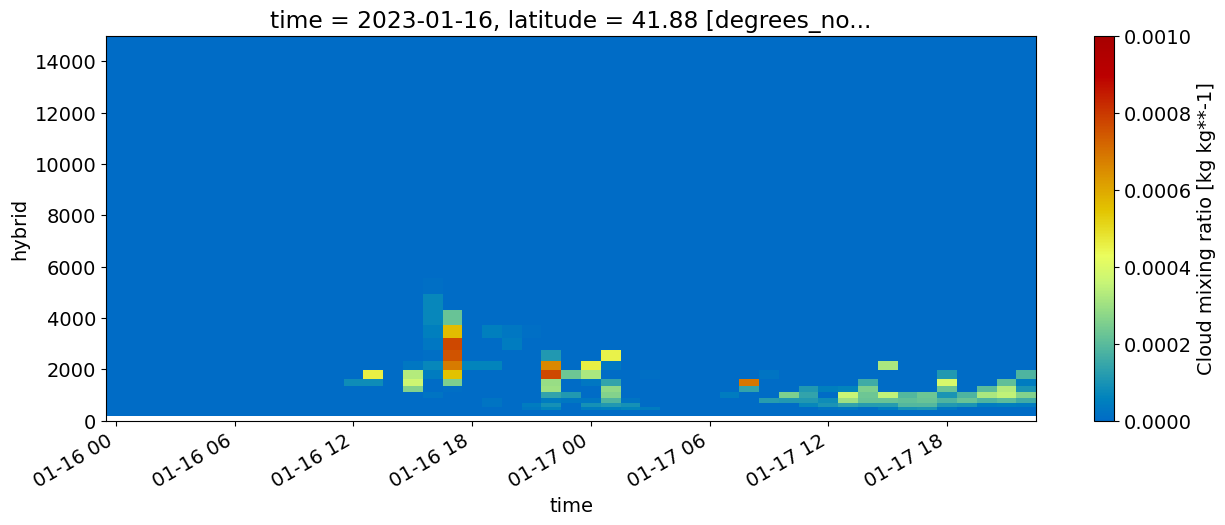

In [48]:
plt.figure(figsize=[15,5])
dsi.isel(point=0).set_index(hybrid="gh_zero").clwmr.plot(x="valid_time", vmin=0, vmax=0.001, 
                                                        cmap = cm_colorblind.HomeyerRainbow)
plt.ylim([0,15000])